## Created by Mukesh Kumar
### This code is part of the LangGraph tutorials, specifically for a Blog Generation workflow.

In [144]:
from langgraph.graph import StateGraph, START, END
from typing import Any, Dict, List, TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
import operator # Needed for merging 

In [145]:
import os
from dotenv import load_dotenv
load_dotenv()

# Import api keys from environment variables
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# print(OPENAI_API_KEY)

In [146]:
class EvaluationSchema(BaseModel):
    feedback: str = Field(..., description="Detailed Feedback of the essay")
    score: float = Field(..., description="Score of the essay on a scale of 1 to 10", ge=1, le=10)

In [147]:
sample_essay = """The Importance of Sustainable Cities for the Future

As the global population continues to grow, cities are becoming increasingly crowded, polluted, and resource-intensive. By 2050, it is estimated that nearly 70% of the world's population will live in urban areas. This shift presents a critical challenge — and opportunity — to reshape our urban environments into sustainable, livable, and resilient cities.

Sustainable cities are designed to meet the needs of their current residents without compromising the ability of future generations to meet their own. This means prioritizing efficient transportation systems, green energy, waste reduction, and access to clean air and water. Public spaces, affordable housing, and equitable access to resources are also central to a truly sustainable urban life.

Transportation is one of the biggest contributors to urban pollution. Cities that invest in electric public transport, cycling infrastructure, and walkable neighborhoods can significantly reduce greenhouse gas emissions. Similarly, incorporating renewable energy into city planning — such as solar-powered buildings and smart grids — can decrease reliance on fossil fuels and improve energy resilience.

Urban planning must also consider social sustainability. Inclusive policies that address poverty, housing inequality, and education gaps create stronger, more cohesive communities. A sustainable city is not only environmentally responsible but also socially just.

Furthermore, green spaces like parks and community gardens improve mental health, reduce urban heat, and support biodiversity — all while strengthening human connections to nature.

In conclusion, sustainable cities are no longer a luxury but a necessity. As climate change accelerates and urban populations rise, cities must evolve to ensure a balanced relationship between people, the environment, and the economy. Investing in sustainable urban development today will shape a more stable, equitable, and thriving world tomorrow.
"""

Gemini

In [ ]:
import google.generativeai as genai

# Configure the SDK
genai.configure(api_key=GEMINI_API_KEY)

# Create a model instance
model = genai.GenerativeModel("models/gemini-2.5-flash")

# Generate content
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {sample_essay}'
# response = model.generate_content(prompt)
# print(response.text)


In [152]:
class UPSCEssayWorkflowState(TypedDict):
    essay :str
    language_quality_feedback: str
    deepth_of_thought_feedback: str
    clarity_of_thought_feedback: str
    overall_feedback: str
    individual_score: Annotated[list[int], Field(description="Scores for each individual feedback category"), operator.add] # Merging scores using operator.add eg. [8] + [9] = [8,9]
    average_score: Annotated[float, Field(description="Average score of the essay on a scale of 1 to 10")]

In [153]:
import json
import re
from typing import Any

def extract_json(text: str) -> dict[str, Any]:
    """
    Extract and parse JSON object from text, ignoring markdown or natural language wrappers.
    """
    # Remove markdown formatting if present
    text = text.strip()
    if text.startswith("```json"):
        text = text[7:]
    if text.endswith("```"):
        text = text[:-3]

    # Find first JSON object using regex
    match = re.search(r'\{.*\}', text, re.DOTALL)
    if match:
        json_str = match.group(0)
        return json.loads(json_str)

    raise ValueError("No valid JSON object found in the response.")


In [154]:
import json

def EvaluateLanguageQuality(state: UPSCEssayWorkflowState) -> UPSCEssayWorkflowState:
    """
    Evaluate the language quality of the essay and provide feedback and score.
    """
    prompt = f"""
Evaluate the language quality of the following essay.

Respond in JSON format with two fields:
- "score": number from 0 to 10
- "feedback": short feedback text

Essay:
{state["essay"]}
"""
    response = model.generate_content(prompt)
    

    try:
        parsed_data = extract_json(response.text)
        evaluation = EvaluationSchema.model_validate(parsed_data)
        return {
            "language_quality_feedback": evaluation.feedback,
            "individual_score": [evaluation.score]
        }
    except Exception as e:
        print("❌ Error parsing or validating response:")
        print(response.text)
        raise e


def EvaluateDeepthOfThought(state: UPSCEssayWorkflowState) -> UPSCEssayWorkflowState:
    """
    Evaluate the depth of thought in the essay and provide feedback and score.
    """
    prompt = f"""
Evaluate the depth of thought in the following essay.

Respond in JSON format with two fields:
- "score": number from 0 to 10
- "feedback": short feedback text

Essay:
{state["essay"]}
"""
    response = model.generate_content(prompt)

    try:
        parsed_data = extract_json(response.text)
        evaluation = EvaluationSchema.model_validate(parsed_data)
        return {
            "deepth_of_thought_feedback": evaluation.feedback,
            "individual_score": [evaluation.score]
        }
    except Exception as e:
        print("❌ Error parsing or validating response:")
        print(response.text)
        raise e


def EvaluateClarityOfThought(state: UPSCEssayWorkflowState) -> UPSCEssayWorkflowState:
    """
    Evaluate the clarity of thought in the essay and provide feedback and score.
    """
    prompt = f"""
Evaluate the clarity of thought in the following essay.

Respond in JSON format with two fields:
- "score": number from 0 to 10
- "feedback": short feedback text

Essay:
{state["essay"]}
"""
    response = model.generate_content(prompt)

    try:
        parsed_data = extract_json(response.text)
        evaluation = EvaluationSchema.model_validate(parsed_data)
        return {
            "clarity_of_thought_feedback": evaluation.feedback,
            "individual_score": [evaluation.score]
        }
    except Exception as e:
        print("❌ Error parsing or validating response:")
        print(response.text)
        raise e


def FinalEvaluation(state: UPSCEssayWorkflowState) -> UPSCEssayWorkflowState:
    """
    Combine all individual scores and feedback to provide a final evaluation of the essay.
    """
    # Average scores
    state['average_score'] = sum(state['individual_score']) / len(state['individual_score']) if state['individual_score'] else 0.0

    # Final feedback prompt
    prompt = (
        f"Based on the following evaluations, provide a comprehensive feedback for the essay:\n"
        f"Language Quality Feedback: {state['language_quality_feedback']}\n"
        f"Depth of Thought Feedback: {state['deepth_of_thought_feedback']}\n"
        f"Clarity of Thought Feedback: {state['clarity_of_thought_feedback']}"
    )

    response = model.generate_content(prompt)
    state['overall_feedback'] = response.text.strip()

    return {
        "overall_feedback": state['overall_feedback'],
        "average_score": state['average_score']
    }


In [155]:
# Define the state graph for the BMI calculator workflow
UPSCEssayflowGraph = StateGraph(UPSCEssayWorkflowState)

# Add nodes to the graph
UPSCEssayflowGraph.add_node('Evaluate_Language_Quality',EvaluateLanguageQuality)
UPSCEssayflowGraph.add_node('Evaluate_Deepth_of_Thought', EvaluateDeepthOfThought)
UPSCEssayflowGraph.add_node('Evaluate_Clarity_of_Thought', EvaluateClarityOfThought)
UPSCEssayflowGraph.add_node('Final_Evaluation', FinalEvaluation)


# Add edges to the graph
UPSCEssayflowGraph.add_edge(START,'Evaluate_Language_Quality')
UPSCEssayflowGraph.add_edge(START, 'Evaluate_Deepth_of_Thought')
UPSCEssayflowGraph.add_edge(START, 'Evaluate_Clarity_of_Thought')
UPSCEssayflowGraph.add_edge('Evaluate_Language_Quality', 'Final_Evaluation')
UPSCEssayflowGraph.add_edge('Evaluate_Deepth_of_Thought', 'Final_Evaluation')
UPSCEssayflowGraph.add_edge('Evaluate_Clarity_of_Thought',  'Final_Evaluation')
UPSCEssayflowGraph.add_edge('Final_Evaluation', END)

# Compile the graph
workflow = UPSCEssayflowGraph.compile()

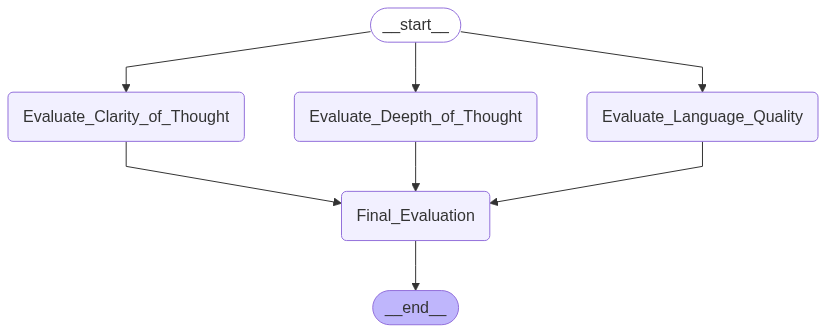

In [156]:
from IPython.display import display, Markdown, Image
Image(workflow.get_graph().draw_mermaid_png())
# display(Markdown("### BMI Calculator Workflow"))

In [157]:
# Execute the workflow
intial_state: UPSCEssayWorkflowState = {
    "essay": sample_essay,
    "language_quality_feedback": "",
    "deepth_of_thought_feedback": "",
    "clarity_of_thought_feedback": "",
    "overall_feedback": "",
    "individual_score": [],
    "average_score": 0.0
}
result_state = workflow.invoke(intial_state)


In [158]:
# Print the final report
# print("Final Report:")
# print(f"Average Score: {result_state['average_score']:.2f}")
# print("Individual Scores:", result_state['individual_score'])

# print(f"Overall Feedback: {result_state['overall_feedback']}")
# Display the final report in a more readable format
display(Markdown(f"""
### Final Report
- **Average Score**: {result_state['average_score']:.2f}
- **Individual Scores**: {result_state['individual_score']}
- **Overall Feedback**: {result_state['overall_feedback']}
"""))



### Final Report
- **Average Score**: 7.50
- **Individual Scores**: [9.0, 4.0, 9.5]
- **Overall Feedback**: This essay demonstrates a strong command of language and excellent clarity of thought, making it a highly readable and well-structured piece.

**Strengths:**

*   **Exceptional Language Quality:** The language quality is a standout feature. Your writing is consistently clear, concise, and grammatically impeccable. The vocabulary used is precise and sophisticated, elevating the prose and contributing to a very professional tone. The essay flows remarkably smoothly, making it a pleasure to read.
*   **Excellent Clarity of Thought:** The essay exhibits excellent clarity of thought. It follows a logical structure with a clear progression of ideas, ensuring that the reader can easily follow your arguments from beginning to end. The precise language used further enhances this clarity, making your central argument and points readily understandable.

**Areas for Development:**

*   **Limited Depth of Thought:** While the essay effectively outlines the common elements and benefits of sustainable cities and demonstrates a clear understanding of basic concepts, it primarily operates at a descriptive, surface level. There is a noticeable lack of deeper analysis or original insight. To strengthen future essays, consider:
    *   **Exploring Complexities and Challenges:** Delve into the inherent difficulties, obstacles, and complexities involved in implementing sustainable urban initiatives.
    *   **Analyzing Trade-offs and Nuances:** Discuss the potential conflicts, compromises, or unintended consequences that might arise when pursuing sustainability goals (e.g., economic costs, social equity issues, political resistance).
    *   **Providing Deeper Analysis:** Move beyond simply describing "what" sustainable cities are and explore "how" they are achieved in practice, "why" certain approaches succeed or fail, and "what are the long-term implications" of different strategies.
    *   **Introducing Original Insight:** Offer a more critical perspective, a unique interpretation, or a well-reasoned argument that goes beyond commonly accepted ideas. This could involve challenging assumptions, presenting counter-arguments, or synthesizing information in a novel way.
    *   **Using Specific Examples/Case Studies:** Integrating detailed examples or case studies could help illustrate complexities and demonstrate a more nuanced understanding.

**Overall Feedback:**

You have built a very strong foundation with your excellent command of language and clarity of expression. These are crucial skills that make your essay highly accessible and professional. The primary opportunity for growth lies in pushing beyond a descriptive overview to engage more deeply with the topic. By incorporating critical analysis, exploring complexities, and offering more nuanced insights, your essays will undoubtedly achieve a higher level of academic sophistication and analytical rigor.


In [159]:
essay2 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""

In [160]:
# Execute the workflow
intial_state: UPSCEssayWorkflowState = {
    "essay": sample_essay
}
result_state = workflow.invoke(intial_state)


In [161]:
display(Markdown(f"""
### Final Report
- **Average Score**: {result_state['average_score']:.2f}
- **Individual Scores**: {result_state['individual_score']}
- **Overall Feedback**: {result_state['overall_feedback']}
"""))


### Final Report
- **Average Score**: 8.00
- **Individual Scores**: [9.0, 6.0, 9.0]
- **Overall Feedback**: Here's a comprehensive feedback for your essay, based on the provided evaluations:

This essay demonstrates a strong command of academic writing, particularly in its language quality and clarity of thought. While it effectively outlines the key components of sustainable cities, there is an opportunity to deepen the analytical engagement with the topic.

### **Overall Strengths:**

Your essay's most significant strengths lie in its **outstanding linguistic proficiency and exceptional clarity of thought**. The writing is a pleasure to read, characterized by precise vocabulary, impeccable grammar, and a logical flow that makes complex ideas accessible. You have successfully created a highly coherent and well-structured argument.

### **Detailed Feedback:**

1.  **Language Quality: Outstanding**
    *   **Strengths:** Your command of language is truly exemplary. The "outstanding clarity, precise vocabulary, and impeccable grammar" significantly contribute to a "highly effective and persuasive argument." You consistently employ "sophisticated language appropriately," which elevates the essay's academic tone without sacrificing readability. The natural and "logical flow" ensures that the reader can follow your reasoning effortlessly. This linguistic excellence not only showcases your writing skills but also enhances the overall credibility and impact of your ideas.

2.  **Clarity of Thought: Excellent**
    *   **Strengths:** The "excellent clarity of thought" is a major highlight. You have a remarkable ability to structure your ideas logically and systematically. The essay "clearly defines its terms" from the outset and "breaks down the components of sustainable cities" in an organized manner. The "strong and coherent flow" ensures that "each point builds effectively on the last," guiding the reader smoothly through your argument. This meticulous organization makes the essay "very easy to follow" and ensures that your message is conveyed with maximum impact.

3.  **Depth of Thought: Area for Development**
    *   **Strengths:** The essay provides a "clear and well-structured overview of key components of sustainable cities," effectively covering both environmental and social aspects. You've clearly grasped the fundamental elements of the topic.
    *   **Areas for Improvement:** While the breadth of coverage is good, the primary area for development lies in the depth of your analysis. The feedback indicates that the essay "largely presents commonly accepted ideas without delving into deeper analysis, specific challenges, or nuanced complexities of implementation."
        *   **Recommendation for Future Essays:** To elevate your work, consider moving beyond a descriptive overview. Engage more critically with the concepts. For instance:
            *   **Explore "How" and "Why":** Instead of just listing components, delve into *how* they are implemented in real-world scenarios, *why* certain approaches are preferred, or *what* the underlying theoretical frameworks are.
            *   **Identify Challenges and Solutions:** Discuss the practical, political, economic, or social challenges associated with implementing sustainable city initiatives. What are the obstacles? How are they being overcome?
            *   **Introduce Nuance and Debate:** Are there different schools of thought on what constitutes a truly sustainable city? Are there conflicting priorities? Examining counter-arguments or potential drawbacks of certain solutions can add significant depth.
            *   **Incorporate Specific Examples/Case Studies:** Referencing specific cities, projects, or policies could provide concrete evidence and demonstrate a more profound understanding of the practical application of these concepts.
            *   **Critical Evaluation:** Rather than just presenting information, evaluate the effectiveness, limitations, or long-term implications of the components you discuss.

### **Conclusion:**

You possess a remarkable foundation in clear and effective academic communication, as evidenced by your superior language quality and clarity of thought. These are invaluable strengths that make your writing highly accessible and persuasive. To achieve an even higher level of academic excellence, your next step should be to leverage these strengths to push for greater intellectual depth. By moving beyond descriptive overviews to engage in more critical, analytical, and nuanced exploration of your chosen topics, you can transform an excellent presentation of ideas into a truly insightful and thought-provoking analysis.
